# Background

Twitter is a micro-blogging social media platform with 217.5 million daily active users globally. With 500 million new tweets (posts) daily, the topics of these tweets varies widely – k-pop, politics, financial news… you name it! Individuals use it for news, entertainment, and discussions, while corporations use them to as a marketing tool to reach out to a wide audience. Given the freedom Twitter accords to its user, Twitter can provide a conducive environment for productive discourse, but this freedom can also be abused, manifesting in the forms of racism and sexism. 

# Problem Statement

With Twitter’s significant income stream coming from advertisers, it is imperative that Twitter keeps a substantial user base. On the other hand, Twitter should maintain a safe space for users and provide some level of checks for the tweets the users put out into the public space, and the first step would be to identify tweets that espouse racist or sexist ideologies, and then Twitter can direct the users to appropriate sources of information where users can learn more about the community that they offend or their subconscious biases so they will be more aware of their racist/sexist tendencies. Thus, to balance, Twitter has to be accurate in filtering inappropriate tweets from innocuous ones, and the kind of inappropriateness of flagged tweets (tag - racist or sexist).

F1-scores will be the primary metric as it looks at both precision and recall, each looking at false positives (FPs) and false negatives (FNs) respectively, and is a popular metric for imbalanced data as is the case with the dataset used.

For the purpose of explanation, racist tweets are used as the ‘positive’ case.

In this context, FPs are the cases where the model erroneously flags out tweets as racist when the tweet is actually innocuous/sexist. FNs are cases where the model erroneously flags out tweets as innocuous/sexist but the tweets are actually racist.

Thus, higher F1-scores are preferred.

# Importing Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP data cleaning and preprocessing
import re, string, nltk, itertools
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Pickle to save model
import pickle

# For showing time
import time

# For NLP Machine Learning processes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Pipeline
from imblearn.pipeline import Pipeline

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Support Vector Machine
from sklearn.svm import SVC

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

In [2]:
# Checking if CUDA is working as intended
print(torch.cuda.is_available())
print(torch.zeros(1).cuda())
print(torch.__version__)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
torch.cuda.empty_cache()

True
tensor([0.], device='cuda:0')
1.12.0
1
0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15933735565211460591
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2410990796
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6754359928859800585
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


In [4]:
# Setting seed for reproducibility
import random

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [5]:
# Changing display settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_colwidth', None)

# Importing Dataset

In [6]:
twitter = pd.read_csv('../Capstone/data/twitter_char_4_gram_lemm_text.csv')

In [7]:
twitter.columns

Index(['Annotation', 'Text_lemm_char_4_gram'], dtype='object')

In [8]:
twitter.head()

,Annotation,Text_lemm_char_4_gram
0,0,read cont onte ntex text extn xtno chan hang ange mean eani anin ning hist isto stor tory isla slam lami amic slav lave aver very
1,0,idio diot clai laim peop eopl ople stop beco ecom come terr erro rror rori oris rist make terr erro rror rori oris rist isla slam lami amic mica ical call ally brai rain dead
2,1,call sexi exis xist auto plac lace woul ould rath athe ther talk
3,2,wron rong foll ollo llow exam xamp ampl mple moha oham hamm amme mmed qura uran exac xact actl ctly
4,0,saud audi prea reac each ache cher tort ortu rtur ture five year earo arol rold daug augh ught ghte hter deat eath rele elea leas ease


In [38]:
twitter.shape

(16299, 2)

In [9]:
flag = ['none', 'sexism', 'racism']

# Train/Test Split

In [10]:
# Splitting the creating the X and Y columns for the character 4-gram based on lemmatized text dataset
X, y = twitter['Text_lemm_char_4_gram'].values, twitter['Annotation'].values

In [11]:
# Conducting train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [13]:
# Oversampling to fit majority class (none)
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

### BERT-specific Preprocessing

In [14]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [15]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 7913],
       [   1, 7913],
       [   2, 7913]], dtype=int64)

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [17]:
# Defining a custom tokenizer function using the loaded tokenizer.
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [18]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  183


Choosing the max length as ... (slightly more than the max_length)

In [19]:
MAX_LEN = max_len + 2

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [20]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
D:\Anaconda\envs\Python\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [21]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

### Dataloaders

According to the author of this code (from Kaggle), it is mentioned that the original author of the BERT Model suggests a batch_size of 16 or 32. Since there is a memory allocation issue when using batch_size = 32, I have reduced it to 8.

In [22]:
batch_size = 8

In [23]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modelling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [24]:
%%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        # 3 n_output because there are 3 categories of tweets ('none': 0, 'sexism': 1, 'racism': 2)
        n_output = 3
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        # Add possibility to freeze the BERT model
        # to avoid fine tuning BERT params (usually leads to worse results)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: total: 0 ns
Wall time: 0 ns


Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [25]:
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Defint the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS= 10

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [27]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
D:\Anaconda\envs\Python\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed i

# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [28]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [29]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.909376   |  178.17  
   200    |   0.694939   |  180.46  
   300    |   0.679346   |  195.61  
   400    |   0.652831   |  195.80  
   500    |   0.644261   |  195.63  
   600    |   0.634829   |  195.57  
   700    |   0.611968   |  195.59  
   800    |   0.579748   |  181.18  
   900    |   0.571644   |  173.86  
  1000    |   0.574575   |  173.76  
  1100    |   0.567758   |  173.75  
  1200    |   0.545248   |  173.78  
  1300    |   0.525739   |  191.52  
  1400    |   0.518865   |  184.21  
  1500    |   0.513220   |  183.47  
  1600    |   0.519220   |  182.02  
  1700    |   0.572164   |  180.42  
  1800    |   0.505104   |  180.45  
  1900    |   0.472122   |  180.45  
  2000    |   0.441135   |  180.44  
  2100    |   0.465543   |  180.47  
  2200    |   0.466226   |  180.46  
  2300    |   0.44

   600    |   0.078465   |  196.07  
   700    |   0.179000   |  196.07  
   800    |   0.135226   |  196.11  
   900    |   0.126149   |  196.05  
  1000    |   0.088674   |  195.79  
  1100    |   0.151895   |  195.49  
  1200    |   0.103942   |  195.43  
  1300    |   0.130180   |  195.43  
  1400    |   0.129792   |  195.42  
  1500    |   0.120017   |  195.44  
  1600    |   0.100958   |  195.47  
  1700    |   0.119971   |  195.57  
  1800    |   0.121885   |  195.58  
  1900    |   0.119852   |  195.48  
  2000    |   0.093280   |  195.47  
  2100    |   0.124165   |  195.50  
  2200    |   0.111598   |  195.56  
  2300    |   0.079039   |  196.04  
  2400    |   0.155727   |  195.65  
  2500    |   0.129043   |  192.54  
  2600    |   0.111137   |  178.99  
  2700    |   0.132035   |  174.74  
  2800    |   0.122725   |  173.49  
  2900    |   0.128631   |  172.27  
  2967    |   0.092165   |  114.85  
-------------------------------------------------------------
AVG TRAIN LOS

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [30]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [31]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

# Results from BERT Classifer Model

### Classification Report

In [32]:
print('Classification Report for BERT (10 Epochs) :\n', classification_report(y_test, bert_preds, target_names=flag))

Classification Report for BERT (10 Epochs) :
               precision    recall  f1-score   support

        none       0.84      0.88      0.86      2198
      sexism       0.71      0.60      0.65       668
      racism       0.73      0.69      0.71       394

    accuracy                           0.80      3260
   macro avg       0.76      0.72      0.74      3260
weighted avg       0.80      0.80      0.80      3260



### Confusion Matrix

In [42]:
cf_matrix = confusion_matrix(y_true = y_test, y_pred = bert_preds)

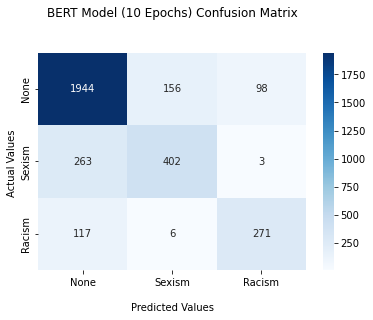

In [43]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('BERT Model (10 Epochs) Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['None','Sexism','Racism'])
ax.yaxis.set_ticklabels(['None','Sexism','Racism'])

## Display the visualization of the Confusion Matrix.
plt.show()

It can be observed that the model best classifies an innocuous tweet as innocuous most of the time, which is unsurprising given the majority tweets are innocuous (tagged as 'none'). 

Generally, the BERT model is able to correctly identify more than half of the inappropriate tweets, with better performance picking out racist tweets. When the tweets are marked as sexist or racist, the model is much more likely to erroneously flag them as innocuous rather than the wrong kind of inappropriateness.

In [44]:
# This is the model variable
type(bert_classifier)

__main__.Bert_Classifier

# Saving BERT Model with 10 Epochs

In [46]:
# Saving Model
pickle.dump(bert_classifier, open("../Capstone/bert_classifier_10epochs.pkl", "wb"))

# Saving Confusion Matrix

In [47]:
pickle.dump(cf_matrix, open("../Capstone/bert_classifier_10epochs_cf_matrix.pkl", "wb"))

In [48]:
# Checking by loading saved confusion matrix
saved_cf = pickle.load(open('../Capstone/bert_classifier_10epochs_cf_matrix.pkl', 'rb'))

In [49]:
# Showing confusion matrix
saved_cf

array([[1944,  156,   98],
       [ 263,  402,    3],
       [ 117,    6,  271]], dtype=int64)